In [1]:
# Designing Intelligent Agents Coursework (COMP 3004)
# Student ID: 20208762
# Title: Reinforcement Learning in a Supply Chain Inventory Management Problem

In [ ]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import numpy as np
from gym import spaces
from gym.utils import seeding
from scipy.stats import poisson
from gym.spaces import Discrete
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# The environment in which the agent operates
class SupplyChainEnv(gym.Env):
    def __init__(self, capacity, lead_time, holding_cost, backorder_cost, mean_demand, seed=88):
        # Maximum inventory capacity that can be held
        self.capacity = capacity
        # Time for an order to be fulfilled
        self.lead_time = lead_time
        # Cost of holding inventory per unit time
        self.holding_cost = holding_cost
        # Cost of not being able to fulfill an order
        self.backorder_cost = backorder_cost
        # Average demand per unit time
        self.mean_demand = mean_demand
        # Current inventory level
        self.inventory = 0
        # Current order level
        self.order = 0
        # Time until next shipment arrives
        self.time_to_shipment = 0
        # Random number generator
        self.np_random = np.random.default_rng(seed)
        # Initial inventory level
        self.initial_inventory = 0    
        # Initialize total cost to zero
        self.total_cost = 0
        self.reset()

        # Define action and observation spaces
        self.action_space = Discrete(self.capacity + 1)
        self.observation_space = gym.spaces.Box(low=0, high=self.capacity, shape=(1,), dtype=int)
    
    def reset(self):
        # Reset environment to initial state
        self.inventory = self.initial_inventory
        self.order = 0
        self.time_to_shipment = 0
        self.time = 0
        return self._get_state()
    
    def step(self, action):
        # Update environment based on agent's action
        reward = 0
        info = {}
        done = False
        
        # Update inventory based on action and demand
        self.inventory -= self.demand_dist(self.time)
        self.inventory += action
        self.inventory = min(self.inventory, self.capacity)
        
        # Check if shipment has arrived
        if self.time_to_shipment > 0:
            self.time_to_shipment -= 1
        else:
            self.order = 0
        
        # Check if new shipment needs to be ordered
        if self.order == 0 and self.inventory + self.lead_time <= self.capacity / 2:
            self.order = self.capacity - self.inventory
            self.time_to_shipment = self.lead_time
        
        # Calculate reward
        if self.inventory < self.demand_dist(self.time):
            reward -= self.backorder_cost * (self.demand_dist(self.time) - self.inventory)
        else:
            reward -= self.holding_cost * self.inventory
            
        self.time += 1
        
        if self.time >= 50:
            done = True
            
        # Update total cost
        self.total_cost += -reward
        self.time += 1
        if self.time >= 50:
            done = True
        info['cost'] = self.total_cost
        
        return self._get_state(), reward, done, info
    
    def _get_state(self):
        return (self.inventory, self.order, self.time_to_shipment, self.time)
    
    def demand_dist(self, time):
        # Generate demand for current time step
        return np.random.poisson(self.mean_demand)


class RLAgent:
    def __init__(self, env, discount_rate=0.95, learning_rate=0.1, exploration_rate=1.0):
        self.env = env
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        # Stores the Q-values for each state-action pair
        self.exploration_rate = exploration_rate
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        self.initial_inventory = env.initial_inventory
        self.action_space = env.action_space
    
    def act(self, state):
        self.state = state
        if np.random.rand() < self.exploration_rate:
            self.action = np.random.randint(0, self.env.capacity+1)
        else:
            self.action = np.argmax(self.Q[state])
        return self.action
    
    def update(self, state, action, next_state, reward):
        # Updates Q-table based on the observed state, action, next state, and reward
        # Get Q-values for the next state
        next_q_values = self.q_table[next_state] 
        max_next_q_value = np.max(next_q_values)
        # Get current Q-value for the current state-action pair
        current_q_value = self.q_table[state][action] 
        # Calculate new Q-value based on the observed reward and the maximum Q-value for the next state
        new_q_value = (1 - self.learning_rate) * current_q_value + self.learning_rate * (reward + self.discount_rate * max_next_q_value)
        self.q_table[state][action] = new_q_value  

In [ ]:
# Run experiment to test the performance of a SupplyChainAgent on the SupplyChainEnv environment
def run_experiment(discount_rate, num_runs):
    all_rewards = []
    all_costs = []

    for run in range(num_runs):
      # Initialize environment with the given parameters
      env = SupplyChainEnv(capacity=10, lead_time=2, holding_cost=1, backorder_cost=3, mean_demand=5, seed=88)
      # Initialize agent with the environment and the discount rate
      agent = RLAgent(env, discount_rate=discount_rate, learning_rate=0.1)
      # Set the number of episodes to run
      num_episodes = 500

      # Store the rewards and costs obtained by the agent in each episode
      rewards = []
      costs = []
      total_reward = 0
      
      # Loop over the episodes
      for i in range(num_episodes):
          # Reset environment and get the initial state
          state = env.reset()
          # Set done flag to False
          done = False
          # Initialize episode reward and total cost to zero
          episode_reward = 0
          total_cost = 0

          # Loop until the episode is done
          while not done:
              # Let the agent choose an action based on the current state
              action = agent.act(state)
              # Get the resulting state, reward, and done flag
              next_state, reward, done, info = env.step(action)
              # Make agent update its Q-table based on the experience gained from this action
              agent.update(state, action, next_state, reward)
              # Set current state to the resulting state
              state = next_state
              # Add reward obtained to the episode reward
              episode_reward += reward
              # Add the total cost incurred during this action to the total cost
              total_cost += info['cost']
          total_reward += episode_reward
          rewards.append(episode_reward)
          costs.append(total_cost)

      all_rewards.append(rewards)
      all_costs.append(costs)

    avg_rewards = [sum(r)/num_episodes for r in zip(*all_rewards)]
    avg_costs = [sum(c)/num_episodes for c in zip(*all_costs)]

    return avg_rewards, avg_costs

In [ ]:
# Varying discount rates
# Rate determines the importance of future rewards in the agent's decision-making process
discount_rates = [0.2, 0.4, 0.6, 0.8]
rewards = []
costs = []

# Run experiments
for rate in discount_rates:
    avg_rewards, avg_costs = run_experiment(rate, num_runs=3)
    rewards.append(avg_rewards)
    costs.append(avg_costs)

# Question: How does the discount rate affect the performance of the agent in the inventory management problem?

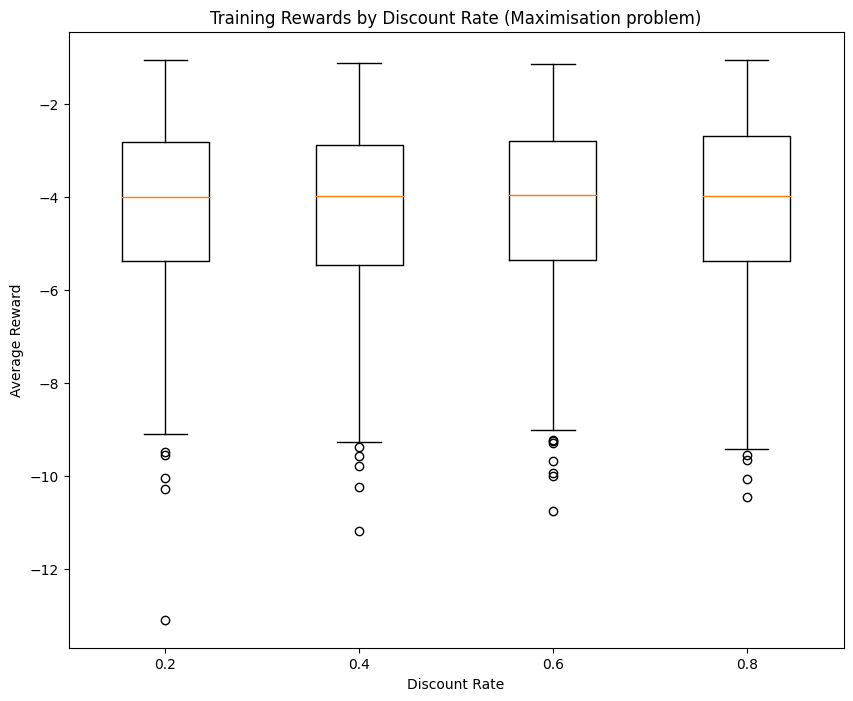


---Training Rewards (Maximisation problem)---
Discount rate = 0.2
Maximum reward: -1.05
Mean reward: -4.29
Minimum reward: -13.09

Discount rate = 0.4
Maximum reward: -1.11
Mean reward: -4.26
Minimum reward: -11.17

Discount rate = 0.6
Maximum reward: -1.13
Mean reward: -4.20
Minimum reward: -10.76

Discount rate = 0.8
Maximum reward: -1.05
Mean reward: -4.15
Minimum reward: -10.45



In [ ]:
# Plot boxplots of Training Rewards
fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(rewards)
ax.set_xticklabels(discount_rates)
ax.set_title("Training Rewards by Discount Rate (Maximisation problem)")
ax.set_xlabel("Discount Rate")
ax.set_ylabel("Average Reward")
plt.show()

# Calculate descriptive statistics for the rewards
print("\n---Training Rewards (Maximisation problem)---")
for i, reward in enumerate(rewards):
    mean_reward = np.mean(reward)
    print(f"Discount rate = {discount_rates[i]}")
    print(f"Maximum reward: {np.max(reward):.2f}")
    print(f"Mean reward: {mean_reward:.2f}")
    print(f"Minimum reward: {np.min(reward):.2f}\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


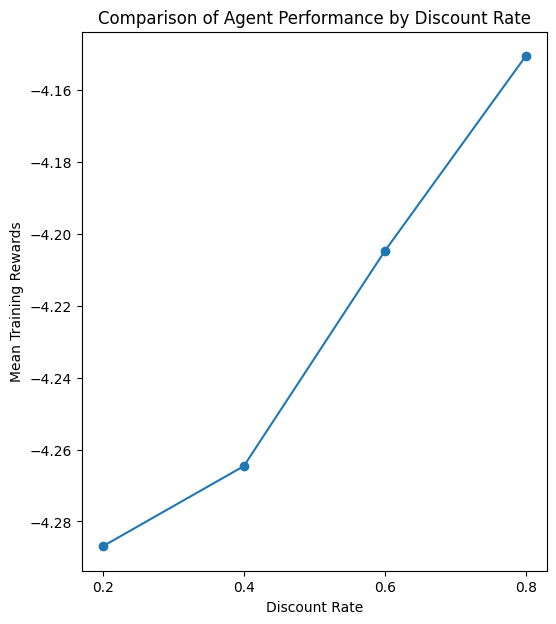

In [ ]:
# Calculate mean rewards for each discount rate
mean_rewards = [np.mean(r) for r in rewards]

# Create the figure and subplots
fig, axs = plt.subplots(figsize=(6,7))

# Plot the mean rewards as a line plot
axs.plot(discount_rates, mean_rewards, marker='o')
# Set the x-axis tick locations
axs.set_xticks(discount_rates)

# Set the labels and title
axs.set_xlabel('Discount Rate')
axs.set_ylabel('Mean Training Rewards')
axs.set_title('Comparison of Agent Performance by Discount Rate')

# Show the plot
plt.show()

# Question:  How does the discount rate in the reinforcement learning agent affect the performance of the inventory management system?

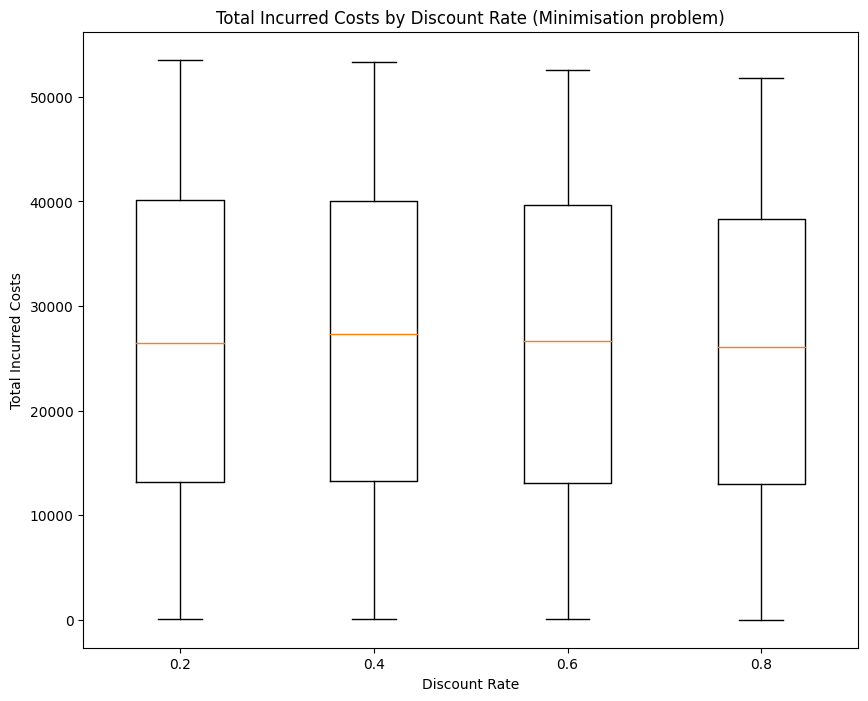


---Total Incurred Costs (Minimisation problem)---
Discount rate = 0.2
Maximum cost: 53546.15
Mean cost: 26692.47
Minimum cost: 55.58

Discount rate = 0.4
Maximum cost: 53291.91
Mean cost: 26827.97
Minimum cost: 47.57

Discount rate = 0.6
Maximum cost: 52539.71
Mean cost: 26485.61
Minimum cost: 89.56

Discount rate = 0.8
Maximum cost: 51832.75
Mean cost: 25843.49
Minimum cost: 20.36



In [ ]:
# Boxplots for Total Incurred Costs
fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(costs)
ax.set_xticklabels(discount_rates)
ax.set_title("Total Incurred Costs by Discount Rate (Minimisation problem)")
ax.set_xlabel("Discount Rate")
ax.set_ylabel("Total Incurred Costs")
plt.show()

# Calculate descriptive statistics for the costs
print("\n---Total Incurred Costs (Minimisation problem)---")
for i, cost in enumerate(costs):
    mean_cost = np.mean(cost)
    print(f"Discount rate = {discount_rates[i]}")
    print(f"Maximum cost: {np.max(cost):.2f}")
    print(f"Mean cost: {mean_cost:.2f}")
    print(f"Minimum cost: {np.min(cost):.2f}\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


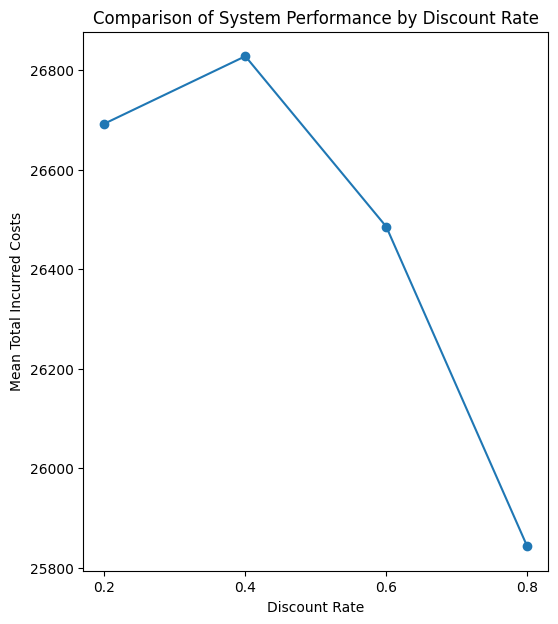

In [ ]:
# Calculate mean costs for each discount rate
mean_costs = [np.mean(c) for c in costs]

# Create the figure and subplots
fig, axs = plt.subplots(figsize=(6,7))

# Plot the mean costs as a line plot
axs.plot(discount_rates, mean_costs, marker='o')
# Set the x-axis tick locations
axs.set_xticks(discount_rates)

# Set the labels and title
axs.set_xlabel('Discount Rate')
axs.set_ylabel('Mean Total Incurred Costs')
axs.set_title('Comparison of System Performance by Discount Rate')

# Show the plot
plt.show()

# Question: What is the correlation between Agent Performance (Training Reward) and System Performance (Total Incurred Costs) as we vary the agent's discount rate?

Correlation coefficient using the mean of rewards and incurred costs: -0.92



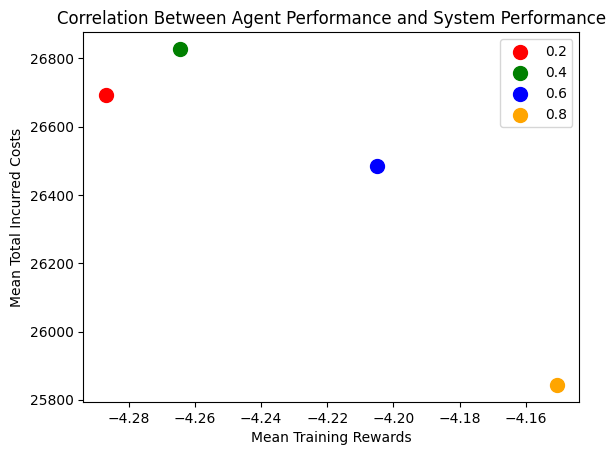

In [ ]:
# Calculate the means of Training Rewards and Total Incurred Costs for each discount rate
reward_means = [np.mean(rewards[i]) for i in range(len(discount_rates))]
cost_means = [np.mean(costs[i]) for i in range(len(discount_rates))]

# Correlation coefficient between the means of Training Rewards and Total Incurred Costs
r = np.corrcoef(reward_means, cost_means)[0, 1]
print('Correlation coefficient using the mean of rewards and incurred costs: {:.2f}\n'.format(r))

# Scatter plot of reward_means vs. cost_means with labeled points
colors = ['red', 'green', 'blue', 'orange']
marker_size = 100
fig, ax = plt.subplots()
for i in range(len(discount_rates)):
    ax.scatter(reward_means[i], cost_means[i], color=colors[i], s=marker_size, label=discount_rates[i])
ax.legend()
plt.xlabel('Mean Training Rewards')
plt.ylabel('Mean Total Incurred Costs')
plt.title('Correlation Between Agent Performance and System Performance')
plt.show()

Based on the correlation coefficient of -0.92 and the scatter plot, it can be seen that there is strong relationship between Agent Performance (Training Rewards) and System Performance (Total Incurred Costs). A higher discount rate leads to a better agent performance and a better system performance.